In [1]:
import torch
from torch import nn
import torchvision.models
import pickle

import torchvision
import torch
from torchvision.transforms import transforms
import numpy as np

In [2]:
class AverageMeter(object):
    """Computes and stores the average and current value
       Imported from https://github.com/pytorch/examples/blob/master/imagenet/main.py#L247-L262
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [3]:
import dataloader_cifar as dataloader

# Dataset loader

def imagenette_dataset():
    size  = 224
    ks = (int(0.1 * size) // 2) * 2 + 1
    __imagenet_stats = {'mean': [0.485, 0.456, 0.406],
                        'std': [0.229, 0.224, 0.225]}

    #TODO: chose transforms

    train_transform = transforms.Compose([
                                            transforms.RandomResizedCrop(224),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.ToTensor(),
                                            transforms.Normalize(**__imagenet_stats)])


    val_transform = transforms.Compose([
                                            transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize(**__imagenet_stats)])

    dataset_train = torchvision.datasets.ImageFolder(os.path.join(dataset_folderpath,'train'), train_transform)
    valid_ds = torchvision.datasets.ImageFolder(os.path.join(dataset_folderpath,'val'), val_transform)

    batch_size = 64
    train_dataloader = torch.utils.data.DataLoader(
            dataset_train,
            batch_size=batch_size,
            num_workers=2,
            drop_last=True,
            shuffle=True,
    )

    val_dataloader = torch.utils.data.DataLoader(
            valid_ds,
            batch_size=batch_size,
            num_workers=2,
            drop_last=True,
            shuffle=False,
    )
    return train_dataloader, val_dataloader

loader = None

def cifar10_dataset(noise_ratio=0.9):
    noise_mode='sym'
    batch_size=32
    data_path='cifar-10-batches-py/cifar-10-batches-py/'
    global loader
    loader = dataloader.cifar_dataloader('cifar10',r=noise_ratio,noise_mode=noise_mode,batch_size=batch_size,num_workers=5,\
        root_dir=data_path,noise_file='%s/%.1f_%s.json'%(data_path,noise_ratio,noise_mode))

    # batch shape: images, noise_label, index
    train_dataloader = loader.run('warmup')

    val_dataloader = loader.run('test')
    return train_dataloader, val_dataloader


train_dataloader, val_dataloader = cifar10_dataset()

loading noise file cifar-10-batches-py/cifar-10-batches-py//0.9_sym.json


In [4]:
def validate(model, val_dataloader):

    model.eval()
    
    with torch.no_grad():

        top1_sum = 0
        top5_sum = 0
        c = 0
        for b in tqdm(val_dataloader):
            x = b[0].cuda()
            y = b[1].cuda()

            y_hat = model(x)

            acc1, acc5 = accuracy(y_hat, y, (1,5))
            top1_sum += y.shape[0] * acc1
            top5_sum += y.shape[0] * acc5
            c += y.shape[0]
        
        top1_acc = top1_sum.item() / c
        top5_acc = top5_sum / c
        print(f"validation acc: top-1: {top1_acc}, top-5: {top5_acc}")
        return top1_acc, top5_acc



In [5]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].flatten().float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [6]:
from collections import OrderedDict
snapshot_name = "simclr_chkpnt/ckpt_cifar10_resnet50.pth"


def fix_state_dict(state_dict):
    # create new OrderedDict that does not contain `module.`
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[len('encoder.module.'):] # remove `module.`
    return new_state_dict

In [7]:
def switch_encoder(model, state):
    for p in model.encoder.parameters():
        p.requires_grad = state

In [8]:
from resnet import SupCEResNet
net = "resnet50"
chekpoint = torch.load(snapshot_name)
sd = {}
for ke in chekpoint['model']:
    nk = ke.replace('module.', '')
    sd[nk] = chekpoint['model'][ke]
model = SupCEResNet(net, num_classes=10)
model.load_state_dict(sd, strict=False)
model = model.to("cuda")

In [9]:
from tqdm.notebook  import tqdm
import copy
from resnet import resnet50
# Stage-2
dw_epochs = 50
criterion = nn.CrossEntropyLoss().cuda()
print_step = 100
out_dir="cifar10/clf_learning"
switch_encoder(model, False)
# validate(model, val_dataloader)
print(f"learnable paramters: {sum(torch.numel(p) for p in model.parameters() if p.requires_grad)}")

# optimizer
lc_opt = torch.optim.SGD(model.parameters(), lr=3e-3 , momentum=0.9)
lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(lc_opt, dw_epochs, 0)
lc_opt.zero_grad()


lin_loss_log = []
lin_epoch_loss = []
acc1_hist = []
acc5_hist = []

def mlp_train():
    model.eval()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val = 0
    for epoch in range(1, dw_epochs + 1):
        total_loss = 0
        # images, noise_label, index
        for batch_idx, (x, y, index) in enumerate(tqdm(train_dataloader)):
            x = x.cuda()
            y = y.cuda()
            y_hat = model(x)
            loss = criterion(y_hat, y)
            
            lc_opt.zero_grad()
            loss.backward()
            lc_opt.step()
            
            total_loss += loss.item()
            lin_loss_log.append(loss.item())
            if batch_idx % print_step == 0:
                tqdm.write('Loss {:.4f}'.format(loss.item()))

        current_epoch_loss = total_loss/len(train_dataloader)
        lin_epoch_loss.append(current_epoch_loss)
        print('Epoch {}: mean loss={:.4f}'.format(epoch, current_epoch_loss))
        lr_sched.step()
        print(f"update lr to: {lc_opt.param_groups[0]['lr']}")
        val,val5 = validate(model, val_dataloader)
        acc1_hist.append(val)
        acc5_hist.append(val5)
        if val > best_val:
            best_val = val
            best_model_wts = copy.deepcopy(model.state_dict())

        model.train()
        print(f"learnable paramters: {sum(torch.numel(p) for p in model.parameters() if p.requires_grad)}")
        if epoch % 10 == 0:
            with open(f"{out_dir}/classifier_loss_logs.pkl", "wb") as f:
                pickle.dump([lin_loss_log, lin_epoch_loss], f)
    return best_model_wts, best_val

# wts, best_val = mlp_train()
# torch.save(wts, f"{out_dir}/final_model_wts.bin")
model.load_state_dict(torch.load(f"{out_dir}/final_model_wts.bin"))
# validate(model, val_dataloader)
# validate(model, loader.run('eval_train'))

learnable paramters: 20490


<All keys matched successfully>

<Figure size 432x288 with 0 Axes>

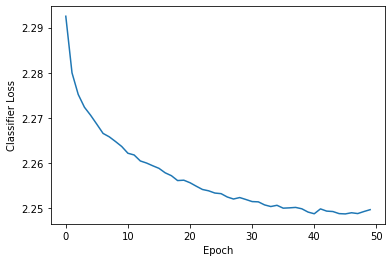

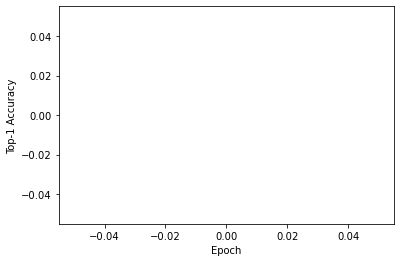

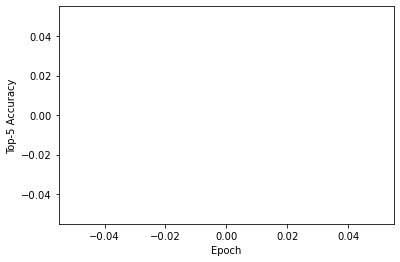

<Figure size 432x288 with 0 Axes>

In [10]:
'''Loading the Classifier Loss logs'''
with open(f"{out_dir}/classifier_loss_logs.pkl",'rb') as f:
    loss = pickle.load(f)
    f.close()
    
from matplotlib import pyplot as plt
plt.plot(loss[1])
# plt.xscale('log')
plt.xlabel('Epoch')
plt.ylabel('Classifier Loss')
plt.figure()


''' plotting the Top-1 & Top-5 accuracy'''
plt.plot(acc1_hist)
plt.xlabel('Epoch')
plt.ylabel('Top-1 Accuracy')
plt.figure()
hist5 = [a.item() for a in acc5_hist]
plt.plot(hist5)
plt.xlabel('Epoch')
plt.ylabel('Top-5 Accuracy')
plt.figure()



loading noise file cifar-10-batches-py/cifar-10-batches-py//0.9_sym.json
torch.Size([50000])
torch.Size([50000])
tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3])
[[0.16946064]
 [0.25153847]]
loading noise file cifar-10-batches-py/cifar-10-batches-py//0.9_sym.json
Confusion matrix before re-labeling


<Figure size 432x288 with 0 Axes>

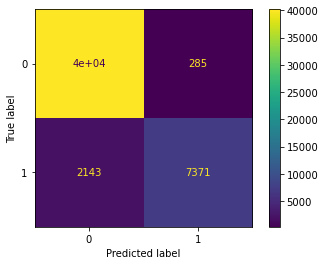

Confusion matrix after re-labeling


<Figure size 432x288 with 0 Axes>

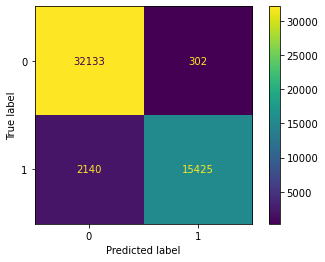

Numer of labeled samples:15727   AUC:0.665

labeled data has a size of 15727
using CBS
loading noise file cifar-10-batches-py/cifar-10-batches-py//0.9_sym.json
unlabeled data has a size of 34273


In [11]:
from sklearn.mixture import GaussianMixture
import dataloader_cifar as dataloader

def get_train(model, dataloader, estimate_p_right=True, p_right_threshold=0.5, p_clean_threshold=0.5, CBS=True):
    model.eval()
    losses = []
    confidence = []
    label_preds = []
    crit = nn.CrossEntropyLoss(reduction='none')
    with torch.no_grad():
        for batch_idx, (inputs, targets, index) in enumerate(dataloader):
            inputs, targets = inputs.cuda(), targets.cuda() 
            outputs = model(inputs)
            b_losses = crit(outputs, targets)
            probs, b_preds = torch.max(torch.softmax(outputs, dim=-1), dim=-1)
            confidence.append(probs)
            label_preds.append(b_preds)
            losses.append(b_losses)

    losses = torch.cat(losses, dim=0).cpu()
    confidence = torch.cat(confidence, dim=0).cpu()
    label_preds = torch.cat(label_preds, dim=0).cpu()
    print(losses.shape)
    print(label_preds.shape)
    print(label_preds[:10])
    losses = (losses-losses.min())/(losses.max()-losses.min())
    
    input_loss = losses.reshape(-1, 1)
    confidence = confidence.reshape(-1, 1)
    # fit a two-component GMM to the loss
    gmm1 = GaussianMixture(n_components=2,max_iter=10,tol=1e-2,reg_covar=5e-4)
    gmm1.fit(input_loss)
    prob = gmm1.predict_proba(input_loss)
    p_clean = prob[:,gmm1.means_.argmin()]
    clean = (p_clean > p_clean_threshold)
    if estimate_p_right:
        gmm2 = GaussianMixture(n_components=2,max_iter=10,tol=1e-2,reg_covar=5e-4)
        gmm2.fit(confidence)
        print(gmm2.means_)
        prob = gmm2.predict_proba(confidence)
        p_right = prob[:, gmm2.means_.argmax()]
        relabel_indicator = p_right > p_right_threshold
        return loader.run('train', clean, p_clean, CBS=CBS,relabel_indicator=relabel_indicator, label_preds=label_preds)

    return loader.run('train', clean, p_clean, CBS=CBS)

labeled_trainloader, unlabeled_trainloader = get_train(model, loader.run('eval_train'), estimate_p_right=True)

In [12]:
def linear_rampup(current, rampup_length=10):
    if rampup_length == 0:
        return 1.0
    else:
        current = np.clip(current / rampup_length, 0.0, 1.0)
        return float(current)

class SemiLoss(object):
    def __call__(self, outputs_x, targets_x, outputs_u, targets_u, epoch, lambda_u=75):
        probs_u = torch.softmax(outputs_u, dim=1)

        Lx = -torch.mean(torch.sum(F.log_softmax(outputs_x, dim=1) * targets_x, dim=1))
        Lu = torch.mean((probs_u - targets_u)**2)

        return Lx, Lu, lambda_u * linear_rampup(epoch)

In [13]:
def interleave_offsets(batch, nu):
    groups = [batch // (nu + 1)] * (nu + 1)
    for x in range(batch - sum(groups)):
        groups[-x - 1] += 1
    offsets = [0]
    for g in groups:
        offsets.append(offsets[-1] + g)
    assert offsets[-1] == batch
    return offsets


def interleave(xy, batch):
    nu = len(xy) - 1
    offsets = interleave_offsets(batch, nu)
    xy = [[v[offsets[p]:offsets[p + 1]] for p in range(nu + 1)] for v in xy]
    for i in range(1, nu + 1):
        xy[0][i], xy[i][i] = xy[i][i], xy[0][i]
    return [torch.cat(v, dim=0) for v in xy]

In [14]:
def kronecker_product(t1, t2):
    """
    Computes the Kronecker product between two tensors.
    See https://en.wikipedia.org/wiki/Kronecker_product
    """
    t1_height, t1_width = t1.shape
    t2_height, t2_width = t2.shape
    out_height = t1_height * t2_height
    out_width = t1_width * t2_width

    tiled_t2 = t2.repeat(t1_height, t1_width)
    expanded_t1 = (
        t1.unsqueeze(2)
          .unsqueeze(3)
          .repeat(1, t2_height, t2_width, 1)
          .view(out_height, out_width)
    )

    return expanded_t1 * tiled_t2

In [15]:
import torch
from torch.nn import ReLU
from torch.nn.functional import normalize
Re = ReLU()
src = torch.ones(32,10)
lab_num = 32# len(L[0])
unlab_num = 64 #len(U)
one_vec1 = torch.ones(lab_num).unsqueeze(dim=0).cuda().detach()
one_vec = torch.ones(unlab_num).unsqueeze(dim=0).cuda().detach()

def graph_structured_regularization(model, L, U, lambda_uu, lambda_lu, tau): #U-unlabled class, L-labled, 
    A_lu = None
    A_uu = None
    with torch.no_grad():
        Z_l = model.encoder(L[0].cuda())
        Z_u = model.encoder(U.cuda())
        Z_l = normalize(Z_l,dim=1)
        Z_u = normalize(Z_u,dim=1)
        A_lu = Re(torch.matmul(Z_l, Z_u.t())-tau)
        A_uu = Re(torch.matmul(Z_u, Z_u.t())-tau)
    y_hat = L[1]
    p = model(U.cuda())
    p = torch.softmax(p, dim=-1)
    P_mat = kronecker_product(one_vec, p).reshape(unlab_num, unlab_num, 10)
    P_mat1 = P_mat[:,:32,:] # kronecker_product(one_vec1, p).reshape(unlab_num, lab_num, 10)
    Y_mat = kronecker_product(one_vec,y_hat).reshape(lab_num, unlab_num,10)
    P_mat1 = torch.transpose(P_mat1,0,1)
    norm_lu = torch.mean((P_mat1 - Y_mat) **2)
    norm_uu = torch.mean((P_mat - torch.transpose(P_mat,0,1) ** 2))
    return  (0.5 * lambda_uu*A_uu*norm_uu).sum() + (lambda_lu*A_lu*norm_lu).sum() 

In [ ]:
import time
from tqdm.notebook  import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.nn import functional as F

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
epochs = 100
lr_sched = CosineAnnealingLR(optimizer, T_max=10, eta_min=0.00005)
optimizer.zero_grad()

def train(labeled_trainloader, unlabeled_trainloader, model, optimizer, criterion, T=0.5, alpha=0.75, train_iteration=1024):
    acc1_hist = []
    acc5_hist = []
    best_val = 0
    switch_encoder(model, state=True)
    print(f"learnable paramters: {sum(torch.numel(p) for p in model.parameters() if p.requires_grad)}")
    for epoch in range(epochs):
        batch_time = AverageMeter()
        data_time = AverageMeter()
        losses = AverageMeter()
        losses_x = AverageMeter()
        losses_u = AverageMeter()
        losses_r = AverageMeter()
        time_loss_r = AverageMeter()

        ws = AverageMeter()
        end = time.time()
        labeled_train_iter = iter(labeled_trainloader)
        unlabeled_train_iter = iter(unlabeled_trainloader)

        model.train()
        for batch_idx in tqdm(range(train_iteration)):
            try:
                inputs_x, targets_x = labeled_train_iter.next()
            except:
                labeled_train_iter = iter(labeled_trainloader)
                inputs_x, targets_x = labeled_train_iter.next()

            try:
                inputs_u, inputs_u2 = unlabeled_train_iter.next()
            except:
                unlabeled_train_iter = iter(unlabeled_trainloader)
                inputs_u, inputs_u2 = unlabeled_train_iter.next()

            # measure data loading time
            data_time.update(time.time() - end)

            batch_size = inputs_x.size(0)

            # Transform label to one-hot
            targets_x = torch.zeros(batch_size, 10).scatter_(1, targets_x.view(-1,1).long(), 1)

            inputs_x, targets_x = inputs_x.cuda(), targets_x.cuda(non_blocking=True)
            inputs_u = inputs_u.cuda()
            inputs_u2 = inputs_u2.cuda()

            with torch.no_grad():
                # compute guessed labels of unlabel samples
                outputs_u = model(inputs_u)
                outputs_u2 = model(inputs_u2)
                p = (torch.softmax(outputs_u, dim=1) + torch.softmax(outputs_u2, dim=1)) / 2
                pt = p ** (1 / T)
                targets_u = pt / pt.sum(dim=1, keepdim=True)
                targets_u = targets_u.detach()

            # mixup
            all_inputs = torch.cat([inputs_x, inputs_u, inputs_u2], dim=0)
            all_targets = torch.cat([targets_x, targets_u, targets_u], dim=0)

            l = np.random.beta(alpha, alpha)

            l = max(l, 1-l)

            idx = torch.randperm(all_inputs.size(0))

            input_a, input_b = all_inputs, all_inputs[idx]
            target_a, target_b = all_targets, all_targets[idx]

            mixed_input = l * input_a + (1 - l) * input_b
            mixed_target = l * target_a + (1 - l) * target_b

            # interleave labeled and unlabed samples between batches to get correct batchnorm calculation 
            mixed_input = list(torch.split(mixed_input, batch_size))
            mixed_input = interleave(mixed_input, batch_size)

            logits = [model(mixed_input[0])]
            for input in mixed_input[1:]:
                logits.append(model(input))

            # put interleaved samples back
            logits = interleave(logits, batch_size)
            logits_x = logits[0]
            logits_u = torch.cat(logits[1:], dim=0)

            Lx, Lu, w = criterion(logits_x, mixed_target[:batch_size], logits_u, mixed_target[batch_size:], epoch+batch_idx/train_iteration)
            R = graph_structured_regularization(model, (inputs_x, targets_x), torch.cat([inputs_u, inputs_u2], dim=0), lambda_uu=0.01, lambda_lu=0.005, tau=0.5)

            loss = Lx + w * Lu + R



            # record loss
            losses.update(loss.item(), inputs_x.size(0))
            losses_x.update(Lx.item(), inputs_x.size(0))
            losses_u.update(Lu.item(), inputs_x.size(0))
            losses_r.update(R.item(), inputs_x.size(0))
            ws.update(w, inputs_x.size(0))

            # compute gradient and do SGD step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            # plot progress
            if batch_idx % 100 == 0:
                print('({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Loss: {loss:.4f} | Loss_x: {loss_x:.4f} | Loss_u: {loss_u:.4f} | Loss_R: {loss_r:.4f} | W: {w:.4f}'.format(
                            batch=batch_idx + 1,
                            size=train_iteration,
                            data=data_time.avg,
                            bt=batch_time.avg,
                            loss=losses.avg,
                            loss_x=losses_x.avg,
                            loss_u=losses_u.avg,
                            loss_r=losses_r.avg,
                            w=ws.avg,
                            ))
            if batch_idx % 500 == 0:
                val,val5 = validate(model, val_dataloader)
                acc1_hist.append(val)
                acc5_hist.append(val5)
                if val > best_val:
                    best_val = val
                    best_model_wts = copy.deepcopy(model.state_dict())
            

        print (losses.avg, losses_x.avg, losses_u.avg,)
        lr_sched.step()
        print(f"update lr to: {optimizer.param_groups[0]['lr']}")
    return(losses.avg, losses_x.avg, losses_u.avg,)

train(labeled_trainloader, unlabeled_trainloader, model, optimizer, criterion=SemiLoss(), T=0.5, alpha=0.75, train_iteration=1024)

learnable paramters: 23520842


(1/1024) Data: 0.680s | Batch: 1.131s | Loss: 1.8664 | Loss_x: 1.8383 | Loss_u: 0.0018 | Loss_R: 0.0281 | W: 0.0000



validation acc: top-1: 84.34, top-5: tensor([98.4400], device='cuda:0')
(101/1024) Data: 0.083s | Batch: 0.486s | Loss: 3.1139 | Loss_x: 2.2009 | Loss_u: 0.0047 | Loss_R: 0.9114 | W: 0.3662
(201/1024) Data: 0.045s | Batch: 0.448s | Loss: 2.9286 | Loss_x: 2.1254 | Loss_u: 0.0048 | Loss_R: 0.7996 | W: 0.7324
(301/1024) Data: 0.033s | Batch: 0.436s | Loss: 2.8016 | Loss_x: 2.0697 | Loss_u: 0.0051 | Loss_R: 0.7259 | W: 1.0986
(401/1024) Data: 0.026s | Batch: 0.428s | Loss: 2.6638 | Loss_x: 1.9875 | Loss_u: 0.0057 | Loss_R: 0.6671 | W: 1.4648
(501/1024) Data: 0.023s | Batch: 0.425s | Loss: 2.5162 | Loss_x: 1.8857 | Loss_u: 0.0065 | Loss_R: 0.6167 | W: 1.8311



validation acc: top-1: 62.95, top-5: tensor([95.0900], device='cuda:0')
(601/1024) Data: 0.032s | Batch: 0.433s | Loss: 2.4069 | Loss_x: 1.8108 | Loss_u: 0.0072 | Loss_R: 0.5775 | W: 2.1973
(701/1024) Data: 0.028s | Batch: 0.430s | Loss: 2.3121 | Loss_x: 1.7462 | Loss_u: 0.0077 | Loss_R: 0.5425 | W: 2.5635
(801/1024) Data: 0.025s | Batch: 0.427s | Loss: 2.2263 | Loss_x: 1.6859 | Loss_u: 0.0081 | Loss_R: 0.5123 | W: 2.9297
(901/1024) Data: 0.023s | Batch: 0.425s | Loss: 2.1519 | Loss_x: 1.6352 | Loss_u: 0.0085 | Loss_R: 0.4838 | W: 3.2959
(1001/1024) Data: 0.022s | Batch: 0.424s | Loss: 2.0755 | Loss_x: 1.5802 | Loss_u: 0.0087 | Loss_R: 0.4584 | W: 3.6621



validation acc: top-1: 77.98, top-5: tensor([98.1300], device='cuda:0')

2.0678691659122705 1.5761511326709297 0.00884042916021599
update lr to: 0.0004889877161664096


(1/1024) Data: 0.941s | Batch: 1.366s | Loss: 1.9859 | Loss_x: 1.8830 | Loss_u: 0.0051 | Loss_R: 0.0648 | W: 7.5000



validation acc: top-1: 74.63, top-5: tensor([98.0300], device='cuda:0')
(101/1024) Data: 0.083s | Batch: 0.486s | Loss: 1.6039 | Loss_x: 1.2176 | Loss_u: 0.0112 | Loss_R: 0.2980 | W: 7.8662
(201/1024) Data: 0.045s | Batch: 0.447s | Loss: 1.5433 | Loss_x: 1.1708 | Loss_u: 0.0116 | Loss_R: 0.2773 | W: 8.2324
(301/1024) Data: 0.033s | Batch: 0.435s | Loss: 1.5065 | Loss_x: 1.1434 | Loss_u: 0.0115 | Loss_R: 0.2641 | W: 8.5986
(401/1024) Data: 0.027s | Batch: 0.429s | Loss: 1.4906 | Loss_x: 1.1347 | Loss_u: 0.0116 | Loss_R: 0.2518 | W: 8.9648
(501/1024) Data: 0.023s | Batch: 0.426s | Loss: 1.4758 | Loss_x: 1.1254 | Loss_u: 0.0117 | Loss_R: 0.2412 | W: 9.3311



validation acc: top-1: 77.43, top-5: tensor([97.7500], device='cuda:0')
(601/1024) Data: 0.032s | Batch: 0.434s | Loss: 1.4673 | Loss_x: 1.1210 | Loss_u: 0.0117 | Loss_R: 0.2327 | W: 9.6973
(701/1024) Data: 0.028s | Batch: 0.430s | Loss: 1.4599 | Loss_x: 1.1148 | Loss_u: 0.0117 | Loss_R: 0.2267 | W: 10.0635
(801/1024) Data: 0.026s | Batch: 0.428s | Loss: 1.4495 | Loss_x: 1.1057 | Loss_u: 0.0116 | Loss_R: 0.2223 | W: 10.4297
(901/1024) Data: 0.024s | Batch: 0.426s | Loss: 1.4451 | Loss_x: 1.1012 | Loss_u: 0.0117 | Loss_R: 0.2180 | W: 10.7959
(1001/1024) Data: 0.022s | Batch: 0.425s | Loss: 1.4404 | Loss_x: 1.0960 | Loss_u: 0.0117 | Loss_R: 0.2141 | W: 11.1621



validation acc: top-1: 78.54, top-5: tensor([97.8000], device='cuda:0')

1.4364053506287746 1.0928524955088506 0.011622030918260862
update lr to: 0.00045702882373436317


(1/1024) Data: 0.965s | Batch: 1.388s | Loss: 1.9932 | Loss_x: 1.7697 | Loss_u: 0.0081 | Loss_R: 0.1018 | W: 15.0000



validation acc: top-1: 81.61, top-5: tensor([98.4600], device='cuda:0')
(101/1024) Data: 0.083s | Batch: 0.488s | Loss: 1.4849 | Loss_x: 1.1149 | Loss_u: 0.0117 | Loss_R: 0.1899 | W: 15.3662
(201/1024) Data: 0.046s | Batch: 0.449s | Loss: 1.4480 | Loss_x: 1.0843 | Loss_u: 0.0116 | Loss_R: 0.1813 | W: 15.7324
(301/1024) Data: 0.033s | Batch: 0.436s | Loss: 1.4419 | Loss_x: 1.0804 | Loss_u: 0.0116 | Loss_R: 0.1745 | W: 16.0986
(401/1024) Data: 0.027s | Batch: 0.429s | Loss: 1.4262 | Loss_x: 1.0673 | Loss_u: 0.0115 | Loss_R: 0.1692 | W: 16.4648
(501/1024) Data: 0.023s | Batch: 0.426s | Loss: 1.4064 | Loss_x: 1.0478 | Loss_u: 0.0114 | Loss_R: 0.1665 | W: 16.8311



validation acc: top-1: 80.01, top-5: tensor([97.2800], device='cuda:0')
(601/1024) Data: 0.032s | Batch: 0.435s | Loss: 1.4020 | Loss_x: 1.0413 | Loss_u: 0.0115 | Loss_R: 0.1636 | W: 17.1973
(701/1024) Data: 0.029s | Batch: 0.431s | Loss: 1.4011 | Loss_x: 1.0392 | Loss_u: 0.0115 | Loss_R: 0.1608 | W: 17.5635
(801/1024) Data: 0.026s | Batch: 0.428s | Loss: 1.4023 | Loss_x: 1.0372 | Loss_u: 0.0115 | Loss_R: 0.1592 | W: 17.9297
(901/1024) Data: 0.024s | Batch: 0.426s | Loss: 1.4043 | Loss_x: 1.0360 | Loss_u: 0.0115 | Loss_R: 0.1578 | W: 18.2959
(1001/1024) Data: 0.023s | Batch: 0.425s | Loss: 1.4018 | Loss_x: 1.0310 | Loss_u: 0.0115 | Loss_R: 0.1565 | W: 18.6621



validation acc: top-1: 81.31, top-5: tensor([97.4800], device='cuda:0')

1.402822107920656 1.0310146927295136 0.011507557567028925
update lr to: 0.0004072516817658065


(1/1024) Data: 0.955s | Batch: 1.369s | Loss: 1.4973 | Loss_x: 1.2222 | Loss_u: 0.0076 | Loss_R: 0.1052 | W: 22.5000



validation acc: top-1: 80.9, top-5: tensor([98.2900], device='cuda:0')
(101/1024) Data: 0.083s | Batch: 0.485s | Loss: 1.4732 | Loss_x: 1.0199 | Loss_u: 0.0112 | Loss_R: 0.1965 | W: 22.8662
(201/1024) Data: 0.046s | Batch: 0.447s | Loss: 1.4339 | Loss_x: 0.9945 | Loss_u: 0.0112 | Loss_R: 0.1799 | W: 23.2324
(301/1024) Data: 0.033s | Batch: 0.435s | Loss: 1.4406 | Loss_x: 1.0027 | Loss_u: 0.0113 | Loss_R: 0.1718 | W: 23.5986
(401/1024) Data: 0.027s | Batch: 0.429s | Loss: 1.4347 | Loss_x: 0.9982 | Loss_u: 0.0112 | Loss_R: 0.1672 | W: 23.9648
(501/1024) Data: 0.024s | Batch: 0.426s | Loss: 1.4365 | Loss_x: 0.9987 | Loss_u: 0.0112 | Loss_R: 0.1656 | W: 24.3311



validation acc: top-1: 78.52, top-5: tensor([96.7400], device='cuda:0')
(601/1024) Data: 0.032s | Batch: 0.434s | Loss: 1.4565 | Loss_x: 1.0130 | Loss_u: 0.0114 | Loss_R: 0.1621 | W: 24.6973
(701/1024) Data: 0.029s | Batch: 0.431s | Loss: 1.4460 | Loss_x: 1.0030 | Loss_u: 0.0113 | Loss_R: 0.1599 | W: 25.0635
(801/1024) Data: 0.026s | Batch: 0.428s | Loss: 1.4565 | Loss_x: 1.0065 | Loss_u: 0.0114 | Loss_R: 0.1600 | W: 25.4297
(901/1024) Data: 0.024s | Batch: 0.426s | Loss: 1.4537 | Loss_x: 1.0001 | Loss_u: 0.0114 | Loss_R: 0.1587 | W: 25.7959
(1001/1024) Data: 0.023s | Batch: 0.425s | Loss: 1.4591 | Loss_x: 1.0023 | Loss_u: 0.0114 | Loss_R: 0.1576 | W: 26.1621



validation acc: top-1: 81.65, top-5: tensor([98.3000], device='cuda:0')

1.4547176326159388 0.9993992149102269 0.011362693254113765
update lr to: 0.0003445288237343632


(1/1024) Data: 0.985s | Batch: 1.398s | Loss: 2.1108 | Loss_x: 1.6289 | Loss_u: 0.0118 | Loss_R: 0.1293 | W: 30.0000



validation acc: top-1: 82.87, top-5: tensor([98.2500], device='cuda:0')
(101/1024) Data: 0.084s | Batch: 0.488s | Loss: 1.5577 | Loss_x: 1.0581 | Loss_u: 0.0118 | Loss_R: 0.1424 | W: 30.3662
(201/1024) Data: 0.046s | Batch: 0.448s | Loss: 1.5183 | Loss_x: 1.0275 | Loss_u: 0.0113 | Loss_R: 0.1427 | W: 30.7324
